<a href="https://colab.research.google.com/github/PedroMSaraiva/heuristics-classes/blob/main/HMM_Aula_6_Estrat%C3%A9gia_Evolutiva.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Estratégia Evolutiva
#### Com base no material de Luis Martí, [IC](http://www.ic.uff.br)/[UFF](http://www.uff.br)



In [ ]:
! sudo apt-get install texlive-latex-recommended
! sudo apt install texlive-latex-extra
! sudo apt install dvipng
! apt install cm-super
! pip install deap
! pip install mealpy
! pip install opfunu

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
texlive-latex-recommended is already the newest version (2021.20220204-1).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
texlive-latex-extra is already the newest version (2021.20220204-1).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
dvipng is already the newest version (1.15-1.1).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
cm-super is already the newest version (0.3.4-17).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
from scipy.stats import norm, multivariate_normal
import math

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['text.latex.preamble'] ='\\usepackage[utf8]{inputenc}'

import seaborn
seaborn.set(style='whitegrid')
seaborn.set_context('notebook')

### Revisão de Estatística

* [Variável aleatória] (http://en.wikipedia.org/wiki/Random_variable): uma variável cujo valor está sujeito a variações devido ao __acaso__. Uma variável aleatória pode assumir um conjunto de possíveis valores diferentes, cada um com uma probabilidade associada, em contraste com outras variáveis matemáticas.

* [Distribuição de probabilidade](http://en.wikipedia.org/wiki/Probability_distribution): função matemática que descreve os possíveis valores de uma variável aleatória e suas probabilidades associadas.

* [Função de densidade de probabilidade(pdf)](http://en.wikipedia.org/wiki/Probability_density_function) de um __variável aletória contínua__ é  uma função que descreve a probabilidade relativa de uma variável aleatório assumir um valor dado.
     * A probabilidade da variável aleatória estar dentro de uma faixa específica de valores é dada pela integral da densidade dessa variável nessa faixa.
     * A função densidade de probabilidade é não negativa em todos os lugares e sua integralidade em todo o espaço é igual a um.
     
<img src='http://upload.wikimedia.org/wikipedia/commons/2/25/The_Normal_Distribution.svg' width='50%' align='center'/>


### [Moments](http://en.wikipedia.org/wiki/Moment_(mathematics)

A distribuição de probabilidade de uma variável aleatória é frequentemente caracterizada por um pequeno número de parâmetros, que também têm uma interpretação prática.

* [Média](http://en.wikipedia.org/wiki/Mean) (também conhecido como valor esperado) refere-se a uma medida da tendência central, seja de uma distribuição de probabilidade ou da variável aleatória caracterizada por essa distribuição.
    * média da população: $\mu = \operatorname{E}[X]$.
    * estimativa da média da amostra: $\bar{x}$.
* [Desvio padrão](http://en.wikipedia.org/wiki/Standard_deviation) mede a quantidade de variação ou dispersão da média.

    * desvio populacional:
    $$
\sigma = \sqrt{\operatorname E[X^2]-(\operatorname E[X])^2} = \sqrt{\frac{1}{N} \sum_{i=1}^N (x_i - \mu)^2}.
$$
    * estimador imparcial:
    $$
    s^2 = \frac{1}{N-1} \sum_{i=1}^N (x_i - \overline{x})^2.
    $$

### Duas amostras

In [ ]:
sample1 = np.random.normal(0, 0.5, 10000)
#print(sample1.size)
sample2 = np.random.normal(1,1,500)

In [ ]:
def plot_normal_sample(sample, mu, sigma):
    'Plots um histograma e a distribuição normal conforme os parâmetros.'
    x = np.linspace(mu - 4*sigma, mu + 4*sigma, 100)
    plt.plot(x, norm.pdf(x, mu, sigma), 'b', lw=2)
    plt.hist(sample, 30, density = True, alpha=0.2)
    plt.annotate('3$\sigma$',
                     xy=(mu + 3*sigma, 0),  xycoords='data',
                     xytext=(0, 100), textcoords='offset points',
                     fontsize=15,
                     arrowprops=dict(arrowstyle="->",
                                    connectionstyle="arc,angleA=180,armA=20,angleB=90,armB=15,rad=7"))
    plt.annotate('-3$\sigma$',
                     xy=(mu -3*sigma, 0), xycoords='data',
                     xytext=(0, 100), textcoords='offset points',
                     fontsize=15,
                     arrowprops=dict(arrowstyle="->",
                                     connectionstyle="arc,angleA=180,armA=20,angleB=90,armB=15,rad=7"))

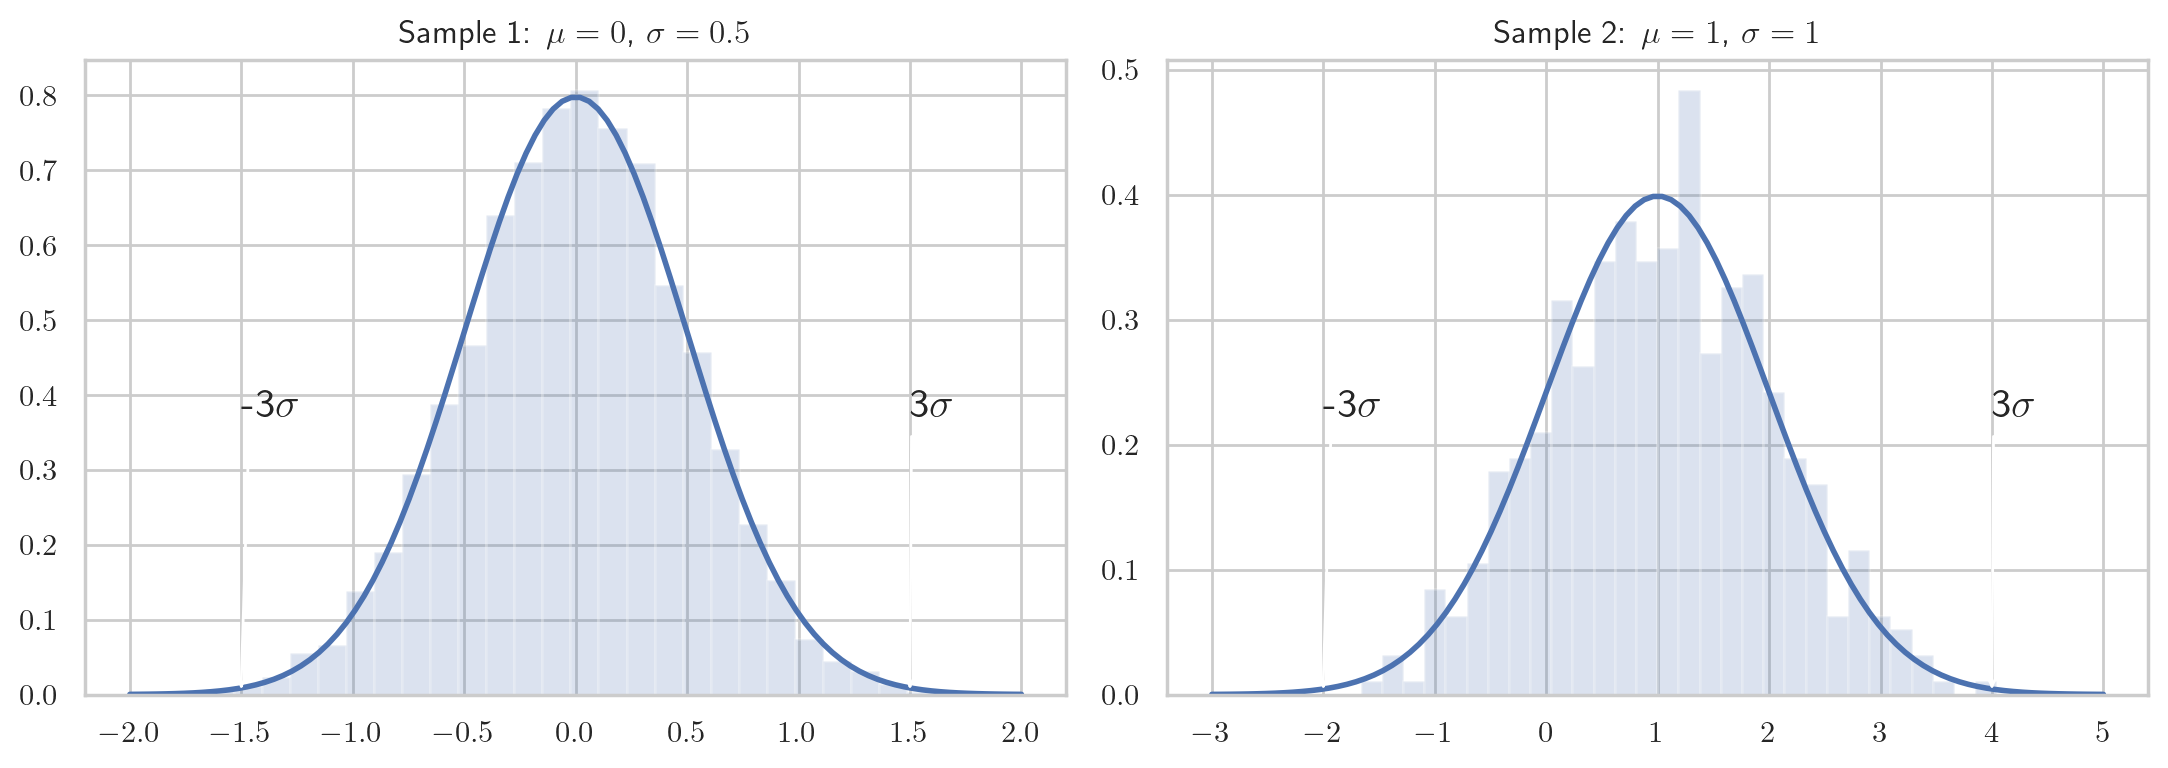

In [ ]:
plt.figure(figsize=(11,4))
plt.subplot(121)
plot_normal_sample(sample1, 0, 0.5)
plt.title('Sample 1: $\mu=0$, $\sigma=0.5$')
plt.subplot(122)
plot_normal_sample(sample2, 1, 1)
plt.title('Sample 2: $\mu=1$, $\sigma=1$')
plt.tight_layout();

In [ ]:
print('Sample 1; estimated mean:', sample1.mean(), ' and std. dev.: ', sample1.std())
print('Sample 2; estimated mean:', sample2.mean(), ' and std. dev.: ', sample2.std())

Sample 1; estimated mean: -0.0015163381029499132  and std. dev.:  0.5017831665503045
Sample 2; estimated mean: 1.030994244825949  and std. dev.:  0.9985752523930059


[Covariância](http://en.wikipedia.org/wiki/Covariance) é uma medida de quanto duas variáveis aleatórias mudam juntas.
$$
\operatorname{cov}(X,Y) = \operatorname{E}{\big[(X - \operatorname{E}[X])(Y - \operatorname{E}[Y])\big]},
$$
$$
\operatorname{cov}(X,X) = s(X),
$$

* O sinal da covariância mostra, portanto, a tendência na relação linear entre as variáveis.
* A magnitude da covariância não é fácil de interpretar.
* A versão normalizada da covariância, o coeficiente de correlação, no entanto, mostra por sua magnitude a força da relação linear.

### Entendendo Covariância

In [ ]:
sample_2d = np.array(list(zip(sample1, np.ones(len(sample1))))).T

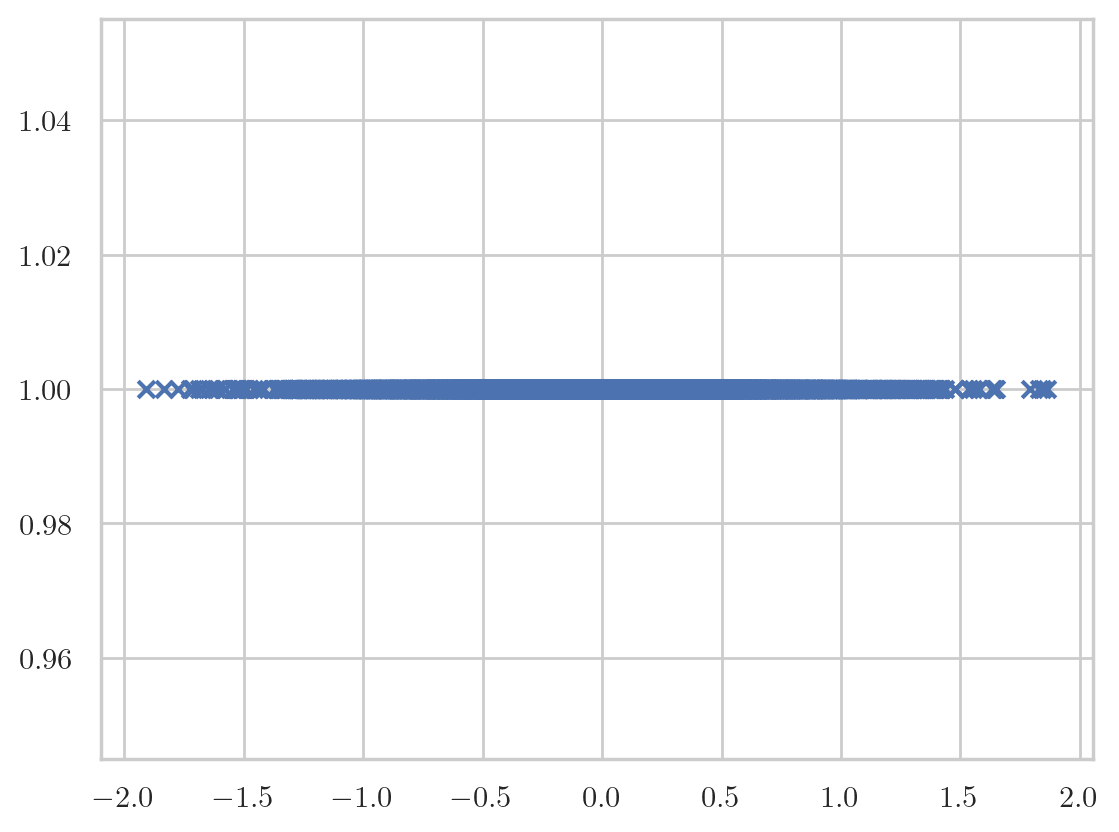

In [ ]:
plt.scatter(sample_2d[0,:], sample_2d[1,:], marker='x');

In [ ]:
np.cov(sample_2d) # computes covariance between the two components of the sample

array([[0.25181153, 0.        ],
       [0.        , 0.        ]])

Como a amostra é distribuída apenas ao longo de um eixo, a covariância não detecta nenhuma relação entre eles.

O que acontece quando nós rotacionamos a amostra?

In [ ]:
def rotate_sample(sample, angle=-45):
    'Rotates a sample by `angle` degrees.'
    theta = (angle/180.) * np.pi
    rot_matrix = np.array([[np.cos(theta), -np.sin(theta)],
                           [np.sin(theta), np.cos(theta)]])
    return sample.T.dot(rot_matrix).T

In [ ]:
rot_sample_2d = rotate_sample(sample_2d)

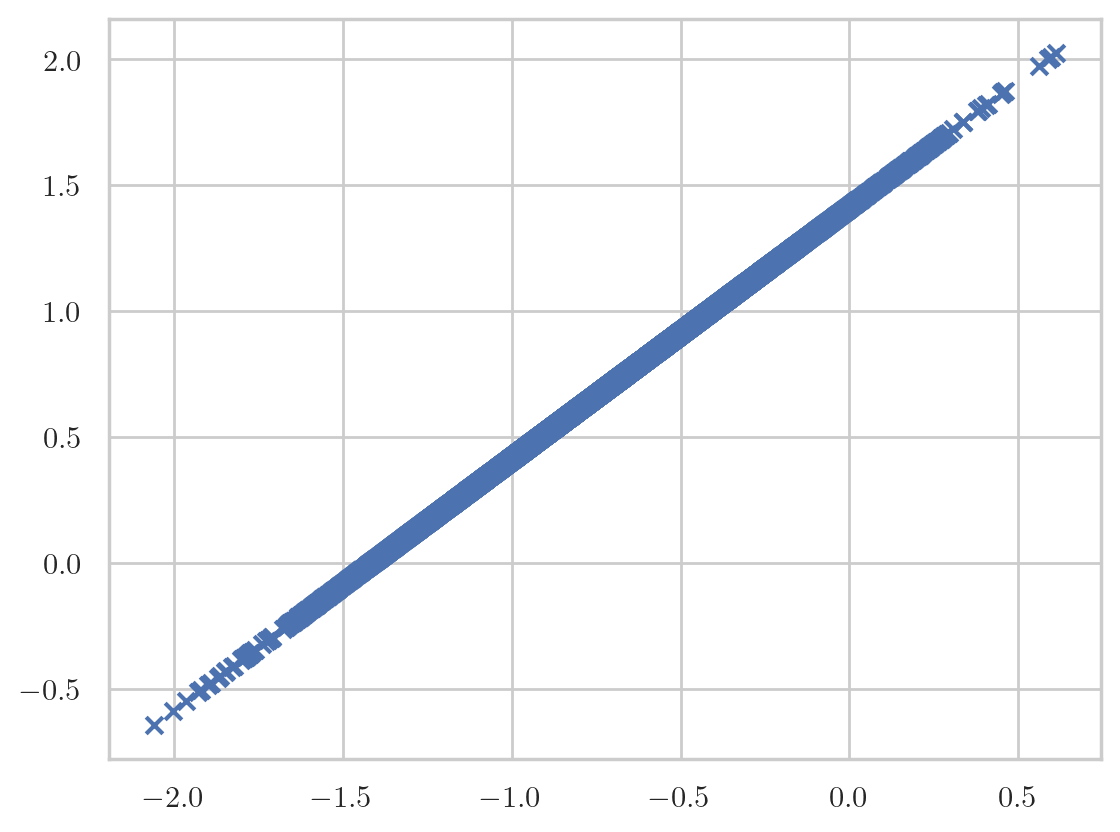

In [ ]:
plt.scatter(rot_sample_2d[0,:], rot_sample_2d[1,:], marker='x');

In [ ]:
np.cov(rot_sample_2d)

array([[0.12590576, 0.12590576],
       [0.12590576, 0.12590576]])

### Uma variável bidimensional normalmente distribuída

<ipython-input-15-56e52f0ab975>:15: UserWarning: The following kwargs were not used by contour: 'lw'
  plt.contour(x, y, rv.pdf(pos), cmap=cm.viridis_r, lw=4)


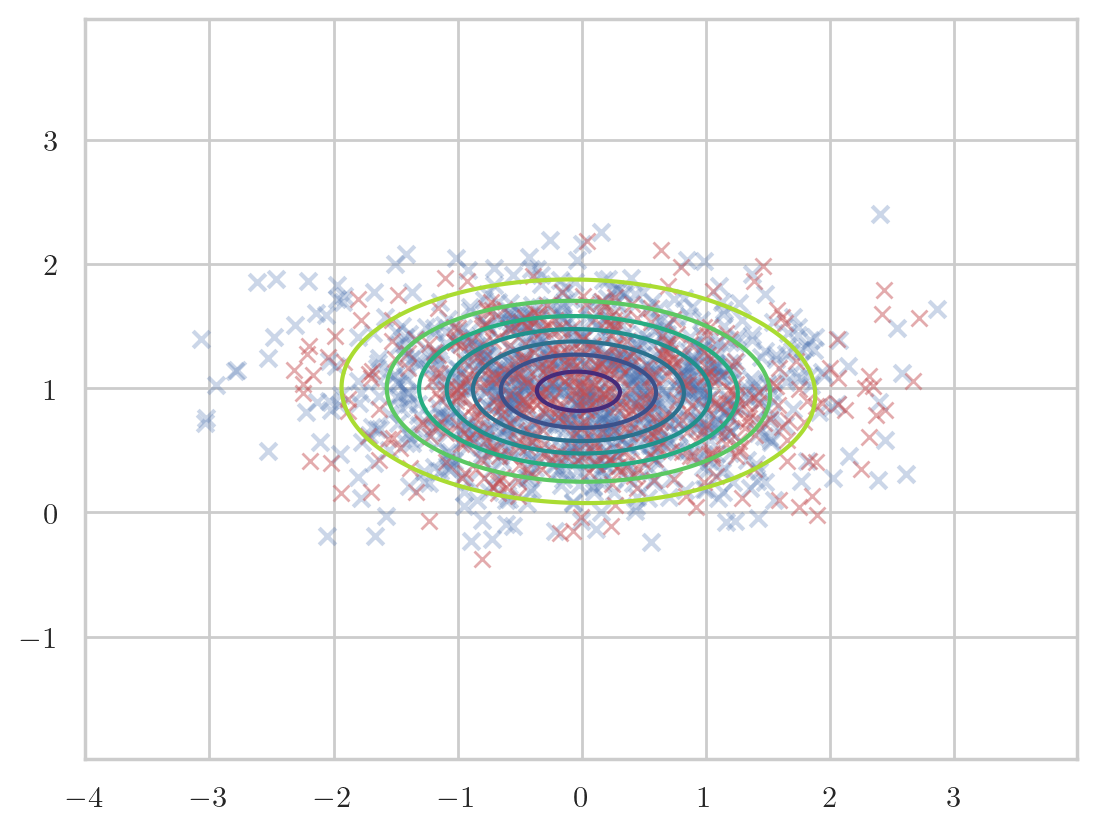

In [ ]:
mu = [0,1]
cov = [[1,0],[0,0.2]] # diagonal covariance, points lie on x or y-axis
sample = np.random.multivariate_normal(mu,cov,1000).T
plt.scatter(sample[0], sample[1], marker='x', alpha=0.29)

estimated_mean = sample.mean(axis=1)
estimated_cov = np.cov(sample)
e_x,e_y = np.random.multivariate_normal(estimated_mean,estimated_cov,500).T

plt.plot(e_x,e_y,'rx', alpha=0.47)
x, y = np.mgrid[-4:4:.01, -1:3:.01]
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y
rv = multivariate_normal(estimated_mean, estimated_cov)
plt.contour(x, y, rv.pdf(pos), cmap=cm.viridis_r, lw=4)
plt.axis('equal');

### Este é melhor visualizado em 3D

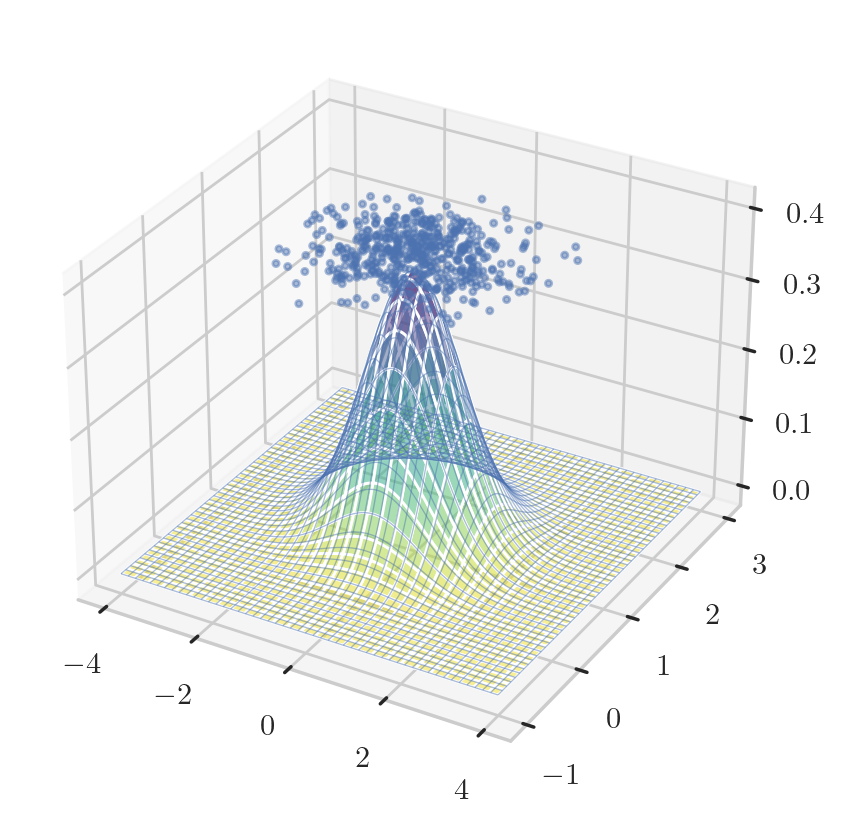

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # Import the Axes3D class

fig = plt.figure(figsize=(11,5))
ax = fig.add_subplot(111, projection='3d') # Use add_subplot to create a 3D subplot
ax.plot_surface(x, y, rv.pdf(pos), cmap=cm.viridis_r, rstride=30, cstride=10, linewidth=1, alpha=0.47)
ax.plot_wireframe(x, y, rv.pdf(pos), linewidth=0.47, alpha=0.47)
ax.scatter(e_x, e_y, 0.4, marker='.', alpha=0.47)
ax.axis('tight');

# Estratégias Evolutivas

Desenvolvido: Alemanha na década de 1970

Nomes antigos: I. Rechenberg, H.-P. Schwefel

Normalmente aplicado a:

*   otimização numérica

Recursos atribuídos:

* velozes
* bom otimizador para otimização com valor real
* relativamente muita teoria

Especial:

* auto-adaptação dos parâmetros (mutação) padrão

# Estratégias Evolutivas

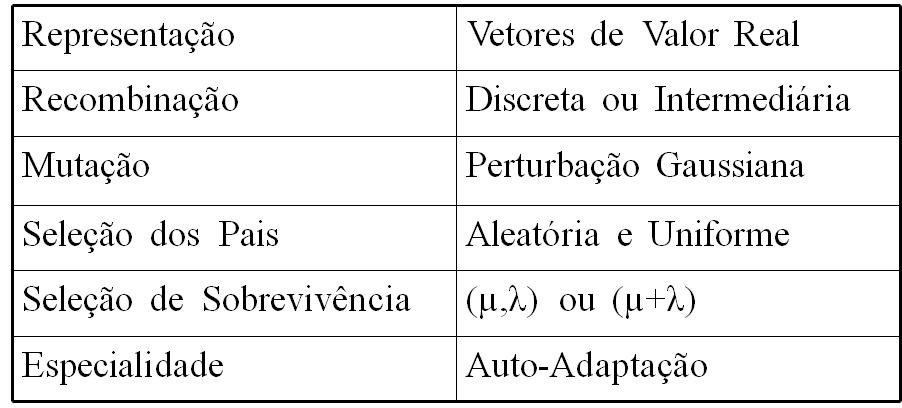

#Exemplo Introdutório

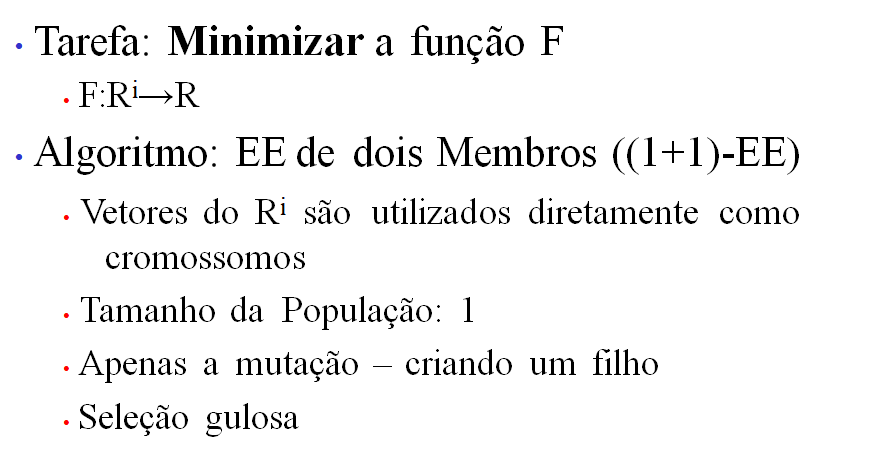

#Pseudo código
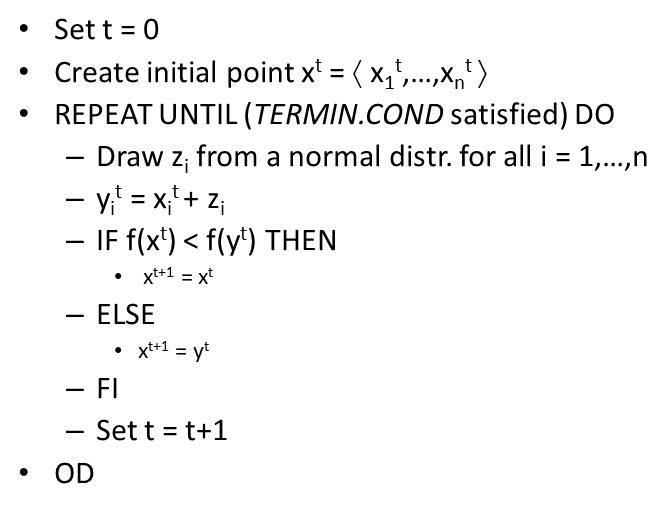

#Mutação
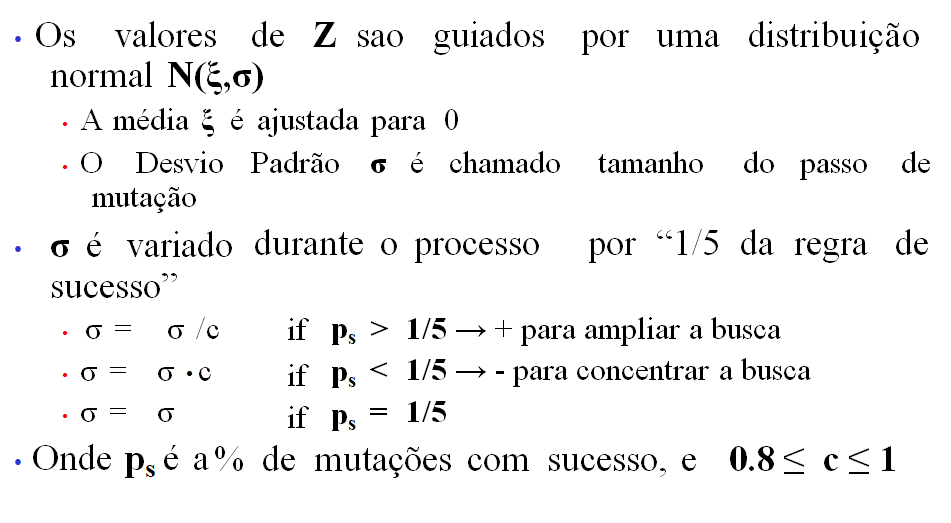

Função a ser otimizada:


![Função Ackley](https://www.sfu.ca/~ssurjano/ackley.png)

In [ ]:
#implementação da EE - 1+1 do pseudocódigo
import math
from math import cos, sqrt, exp
from random import random, randrange, sample, gauss, seed
import numpy as np

n = 30
min_v, max_v = -15.0, 15.0
# tenta mudar esses parametros
t1 = 3.0#1.0/sqrt(2*n)
t2 = 3.0#1.0/sqrt(2*sqrt(n))
min_step, max_step = 1e-8, 10
iterations = 100000

minimum_fitness = 1e20

def rand_in_range(x, y):
	return x + random()*(y-x)

#def disturb_step(x, global_step):
#	x *= np.exp(global_step + t2*np.random.normal(0, 1,x.size))
#	return np.minimum(max_step, np.maximum(min_step, x))

def disturb_step(x, global_step):
	x *= exp(global_step + t2*gauss(0, 1))
	return min(max_step, max(min_step, x))

def disturb(x, s):
	#x.shape
#	print(x,s)
  #print(s)
#	x += s*np.random.normal(0, 1,x.size)
#	print(x)
#	return np.minimum(max_v, np.maximum(min_v, x))
#def disturb(x, s):
	x += s*gauss(0, 1)
	return min(max_v, max(min_v, x))

class Candidate:
	def __init__(self, value=None, step=None):
		if value is None:
			# Aleatory initialization
			self.value = np.random.uniform(min_v, max_v, n)#[rand_in_range(min_v, max_v) for _ in range(n)]
			self.step = np.random.uniform(min_step, max_step,n)
		else:
			# child of somebody
			self.value, self.step = value, step

		# fitness is always calculated, even when the candidate is created
		self.calc_fitness()
		#print(self.fitness)


	def calc_fitness(self):
		a, b, c = 20, 0.2, 2*math.pi
		sum1, sum2 = 0, 0
		for i in self.value:
			sum1 += i**2
			sum2 += cos(c*i)

		self.fitness = -a*exp(-b*sqrt(sum1/n)) - exp(sum2/n) + a + exp(1)

		global minimum_fitness
		if self.fitness < minimum_fitness:
			minimum_fitness = self.fitness

	def cross_alone(self):
		global_step = t1*gauss(0, 1)
		new_step = [disturb_step(x, global_step) for x in self.step]#new_step = disturb_step(self.step, global_step) # for x in self.step]
		new_value = [disturb(self.value[i], new_step[i]) for i in range(n)]#disturb(self.value, new_step)
		#print(new_value)
		return Candidate(new_value, new_step)

def run_single_individual():
	seed()

	# executa mais vezes do que isso, pelo menos umas 30
	for iter in range(10):
		x = Candidate()

		for i in range(iterations):
			y = x.cross_alone()
			#print(y.fitness, x.fitness)#success = (y.fitness < x.fitness)
			if (y.fitness < x.fitness):
				x = y

		print("Execution % d Best Fitness: % 1.10f" %(iter, x.fitness))

if __name__ == "__main__":
	run_single_individual()


Execution  0 Best Fitness:  0.0000000299
Execution  1 Best Fitness:  0.0000000261
Execution  2 Best Fitness:  0.0000000311
Execution  3 Best Fitness:  0.0000000309
Execution  4 Best Fitness:  0.0000000280
Execution  5 Best Fitness:  0.0000000309
Execution  6 Best Fitness:  0.0000000286
Execution  7 Best Fitness:  0.0000000259
Execution  8 Best Fitness:  0.0000000304
Execution  9 Best Fitness:  0.0000000299


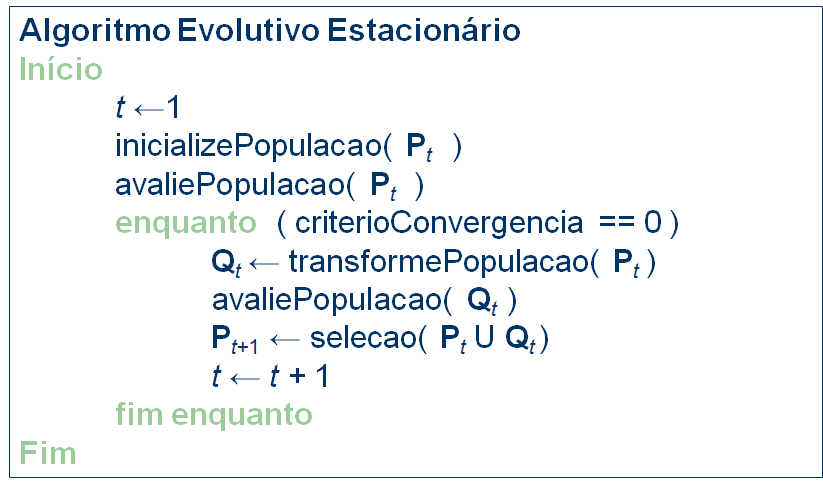

# Outros Modelos de Estratégias Evolutivas

---
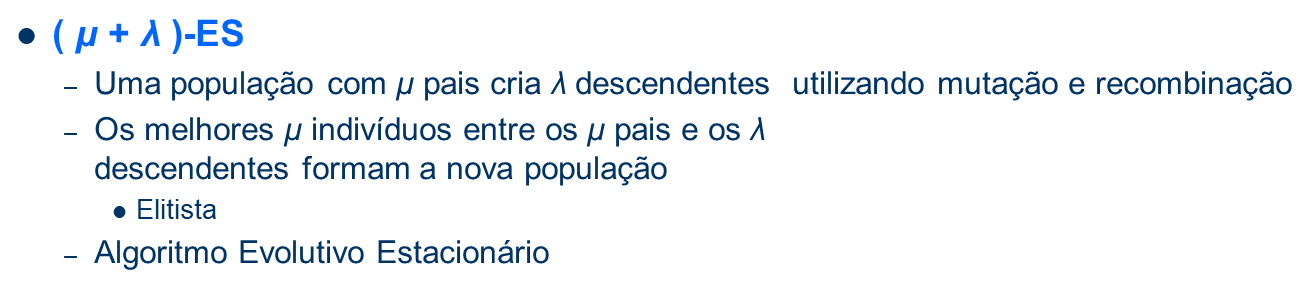


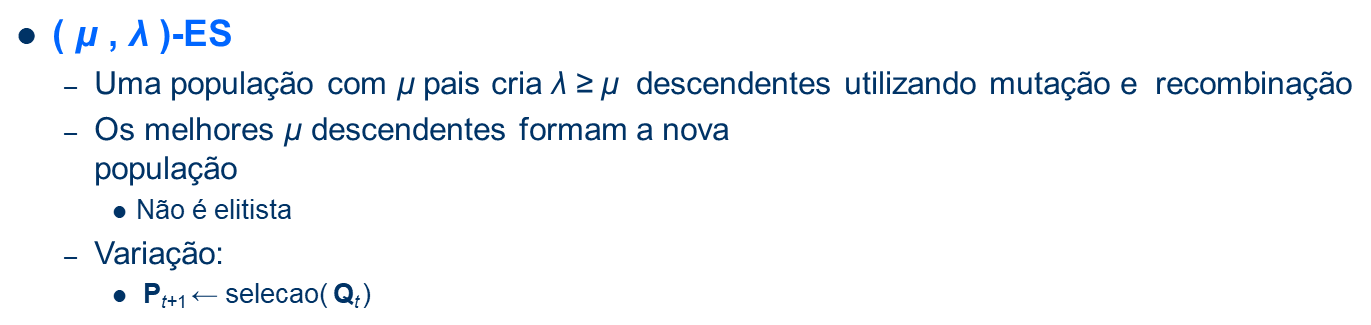

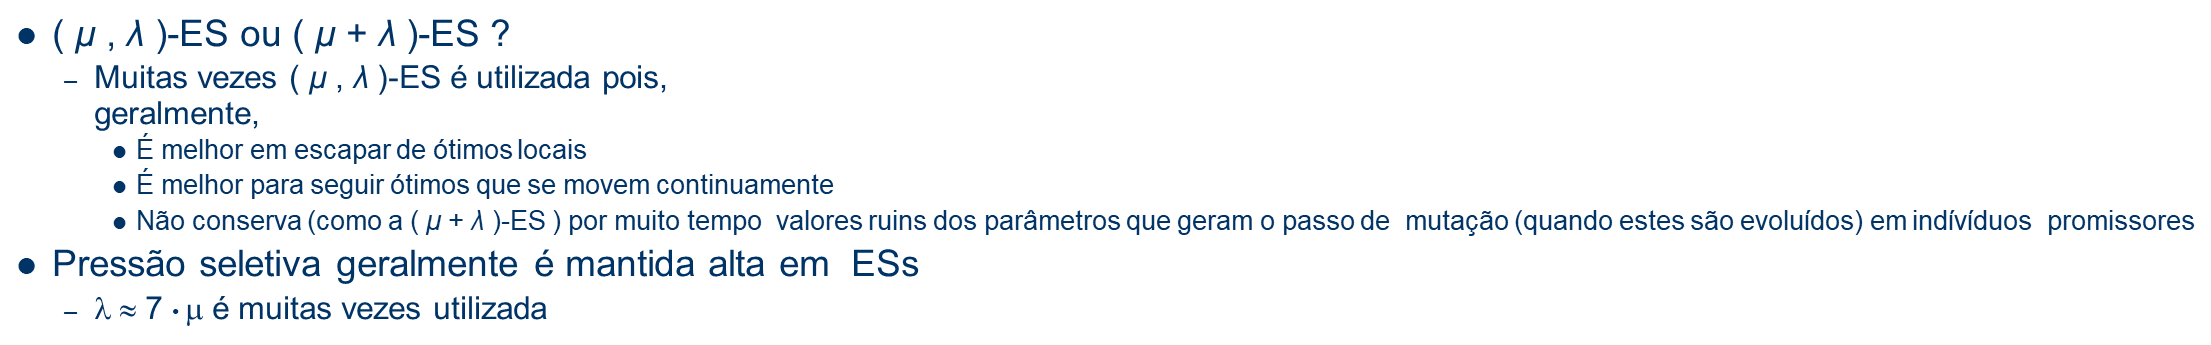

# Estratégias Evolutivas

Nesse exemplo vamos utilizar o framework DEAP para explicar os demais conceitos da ES.

In [ ]:
import array, random, time, copy

from deap import base, creator, benchmarks, tools, algorithms

random.seed(42) # Fixing a random seed: You should not do this in practice.

Before we dive into the discussion lets code some support functions.

In [ ]:
def plot_problem_3d(problem, bounds, resolution=100.,
                    cmap=cm.viridis_r, rstride=10, cstride=10,
                    linewidth=0.15, alpha=0.65, ax=None):
    'Plots a given deap benchmark problem in 3D mesh.'
    (minx,miny),(maxx,maxy) = bounds
    x_range = np.arange(minx, maxx, (maxx-minx)/resolution)
    y_range = np.arange(miny, maxy, (maxy-miny)/resolution)

    X, Y = np.meshgrid(x_range, y_range)
    Z = np.zeros((len(x_range), len(y_range)))

    for i in range(len(x_range)):
        for j in range(len(y_range)):
            Z[i,j] = problem((x_range[i], y_range[j]))[0]

    if not ax:
        fig = plt.figure(figsize=(11,6))
        ax = fig.gca(projection='3d')

    cset = ax.plot_surface(X, Y, Z, cmap=cmap, rstride=rstride, cstride=cstride, linewidth=linewidth, alpha=alpha)

In [ ]:
def plot_problem_controur(problem, bounds, optimum=None,
                          resolution=100., cmap=cm.viridis_r,
                          rstride=1, cstride=10, linewidth=0.15,
                          alpha=0.65, ax=None):
    'Plots a given deap benchmark problem as a countour plot'
    (minx,miny),(maxx,maxy) = bounds
    x_range = np.arange(minx, maxx, (maxx-minx)/resolution)
    y_range = np.arange(miny, maxy, (maxy-miny)/resolution)

    X, Y = np.meshgrid(x_range, y_range)
    Z = np.zeros((len(x_range), len(y_range)))

    for i in range(len(x_range)):
        for j in range(len(y_range)):
            Z[i,j] = problem((x_range[i], y_range[j]))[0]

    if not ax:
        fig = plt.figure(figsize=(6,6))
        ax = fig.gca()
        ax.set_aspect('equal')
        ax.autoscale(tight=True)

    cset = ax.contourf(X, Y, Z, cmap=cmap, alpha=alpha)

    if optimum:
        ax.plot(optimum[0], optimum[1], 'bx', linewidth=4, markersize=15)

In [ ]:
def plot_cov_ellipse(pos, cov, volume=.99, ax=None, fc='lightblue', ec='darkblue', alpha=1, lw=1):
    ''' Plots an ellipse that corresponds to a bivariate normal distribution.
    Adapted from http://www.nhsilbert.net/source/2014/06/bivariate-normal-ellipse-plotting-in-python/'''
    from scipy.stats import chi2
    from matplotlib.patches import Ellipse

    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    kwrg = {'facecolor':fc, 'edgecolor':ec, 'alpha':alpha, 'linewidth':lw}

    # Width and height are "full" widths, not radius
    width, height = 2 * np.sqrt(chi2.ppf(volume,2)) * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwrg)
    ax.add_artist(ellip)

### Why benchmarks (test) functions?

In applied mathematics, [test functions](http://en.wikipedia.org/wiki/Test_functions_for_optimization), also known as artificial landscapes, are useful to evaluate characteristics of optimization algorithms, such as:

* Velocity of convergence.
* Precision.
* Robustness.
* General performance.

DEAP has a number of test problems already implemented. See http://deap.readthedocs.org/en/latest/api/benchmarks.html

### [Bohachevsky benchmark problem](http://deap.readthedocs.org/en/latest/api/benchmarks.html#deap.benchmarks.bohachevsky)

$$\text{minimize } f(\mathbf{x}) = \sum_{i=1}^{N-1}(x_i^2 + 2x_{i+1}^2 - 0.3\cos(3\pi x_i) - 0.4\cos(4\pi x_{i+1}) + 0.7), \mathbf{x}\in \left[-100,100\right]^n,$$

> Optimum in $\mathbf{x}=\mathbf{0}$, $f(\mathbf{x})=0$.

In [ ]:
current_problem = benchmarks.bohachevsky

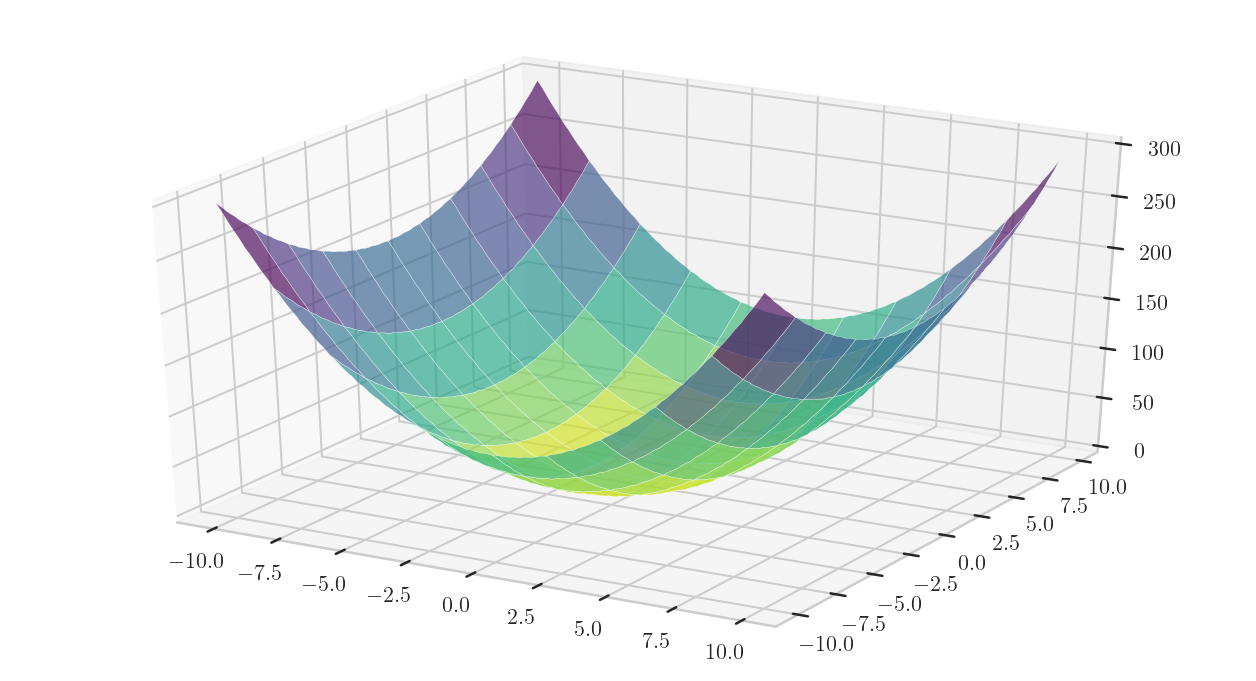

In [ ]:
plot_problem_3d(current_problem, ((-10,-10), (10,10)))

The Bohachevsky problem has many local optima.

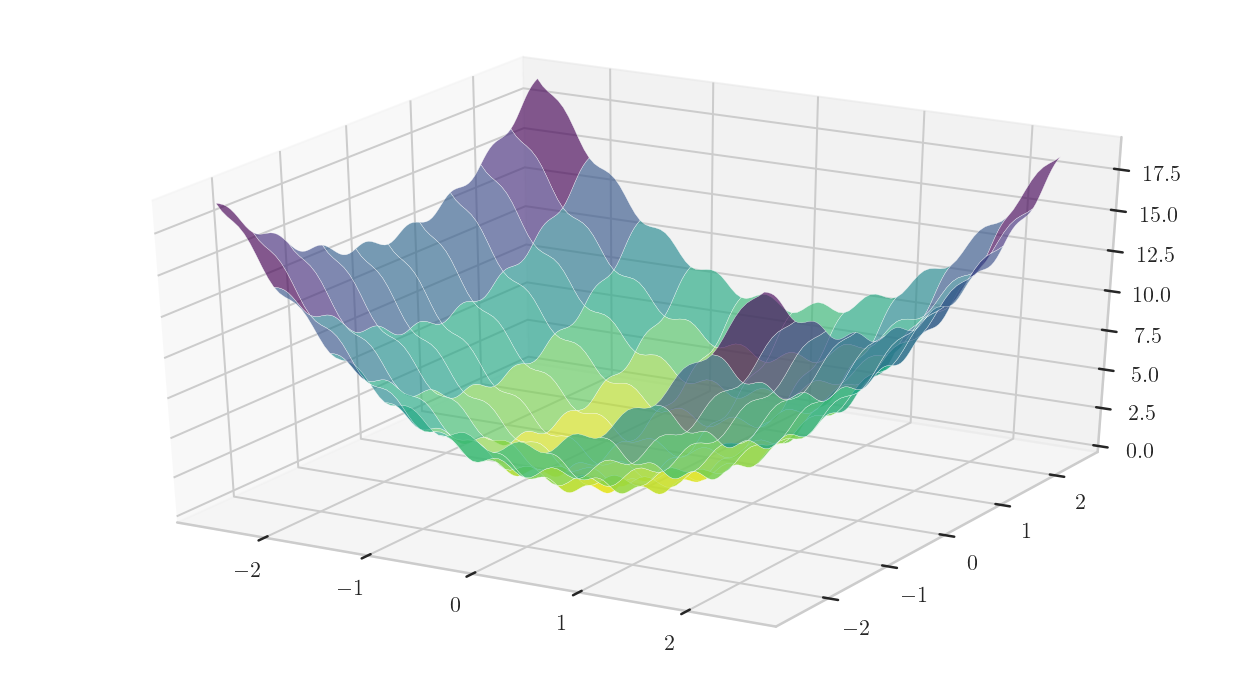

In [ ]:
plot_problem_3d(current_problem, ((-2.5,-2.5), (2.5,2.5)))

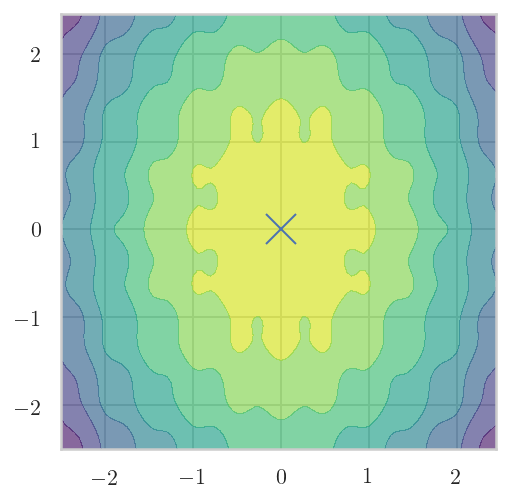

In [ ]:
ax = plt.figure().gca()
plot_problem_controur(current_problem, ((-2.5,-2.5), (2.5,2.5)), optimum=(0,0), ax=ax)
ax.set_aspect('equal')

## ($\mu$,$\lambda$) evolutionary strategy

Some basic initialization parameters.

In [ ]:
search_space_dims = 2 # we want to plot the individuals so this must be 2

MIN_VALUE, MAX_VALUE = -10., 10.
MIN_STRAT, MAX_STRAT = 0.0000001, 1.

In [ ]:
# Cria no DEAP o tipo de função de fitness (Minizar, Maximizar ou Multiobjetivo)
#A função create () recebe pelo menos dois argumentos, um nome para a classe recém-criada e uma classe base.
#O terceiro argumento indica se o problema é de minimizar (negativo), maximizar (positivo), para múltiplos objetivos esse argumento deve ser uma tupla.
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

# Estratégias evolutivas precisam de uma localização (média)
#O primeiro argumento indica que estamos criando o formato indivíduo, o segundo é a estrutura dos indivíduo, o argumento typecode
#está relacionado com o formato de array e indica que serão armazenados somente doubles, o próximo argumento é a vinculação com o objeto do fitness
#Por fim, ao trabalhar com ES é necessário que o campo "strategy" seja adicionado ao indivíduo
creator.create("Individual", array.array, typecode='d',
               fitness=creator.FitnessMin, strategy=None)
# ...e um valor do parâmetro estratégia.
creator.create("Strategy", array.array, typecode="d")

Para criar e inicializar os indivíduos da estratégia evolutiva esse exemplo define uma função própria.

In [ ]:
def init_univariate_es_ind(individual_class, strategy_class,
                           size, min_value, max_value,
                           min_strat, max_strat):
    ind = individual_class(random.uniform(min_value, max_value)
                           for _ in range(size))
    # we modify the instance to include the strategy in run-time.
    ind.strategy = strategy_class(random.uniform(min_strat, max_strat) for _ in range(size))
    return ind

In [ ]:
#Para usar DEAP é necessário inicializar os valores dos objetos por meio do método register.
toolbox = base.Toolbox()
toolbox.register("individual", init_univariate_es_ind,
                 creator.Individual,
                 creator.Strategy,
                 search_space_dims,
                 MIN_VALUE, MAX_VALUE,
                 MIN_STRAT, MAX_STRAT)
toolbox.register("population", tools.initRepeat, list,
                 toolbox.individual)

Como é um indivíduo e uma população?

In [ ]:
ind = toolbox.individual()
pop = toolbox.population(n=3)
print(ind)
print(ind.strategy)
print(pop)

array('d', [2.7885359691576745, -9.49978489554666])
array('d', [0.27502939086618744, 0.22321081582774896])
[array('d', [4.729424283280249, 3.533989748458225]), array('d', [-1.561563606294591, -9.404055611238594]), array('d', [-9.469280606322727, -6.02324698626703])]


In [ ]:
def plot_individual(individual, ax=None):
    'Plots an ES indiviual as center and 3*sigma ellipsis.'
    cov = np.eye(len(individual)) * individual.strategy
    plot_cov_ellipse(individual, cov, volume=0.99, alpha=0.56, ax=ax)
    if ax:
        ax.scatter(individual[0], individual[1],
                    marker='+', color='k', zorder=100)
    else:
        plt.scatter(individual[0], individual[1],
                    marker='+', color='k', zorder=100)


def plot_population(pop, gen=None, max_gen=None, ax=None):
    if gen:
        plt.subplot(max_gen, 1, gen)

    for ind in pop:
        plot_individual(ind, ax)

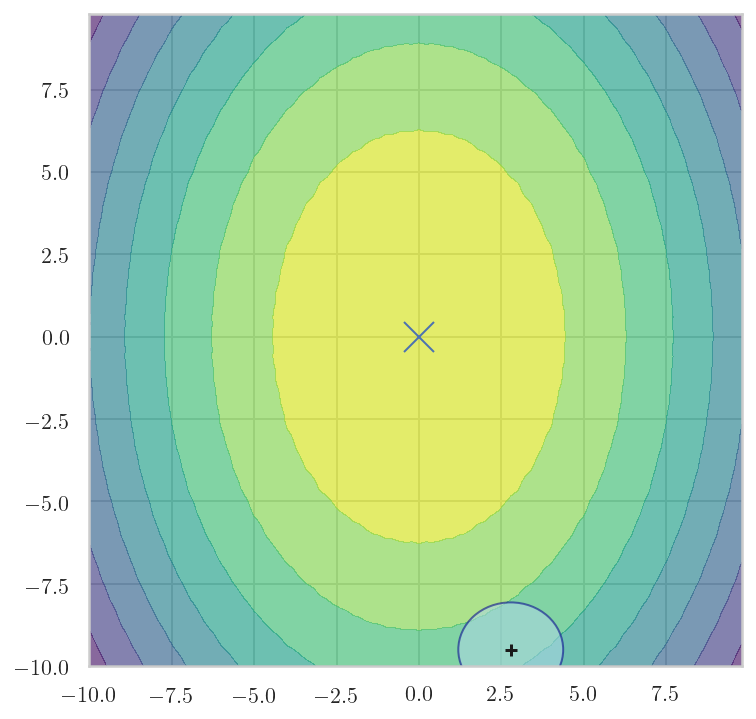

In [ ]:
plot_problem_controur(current_problem, ((-10,-10), (10,10)), optimum=(0,0))
plot_individual(ind)

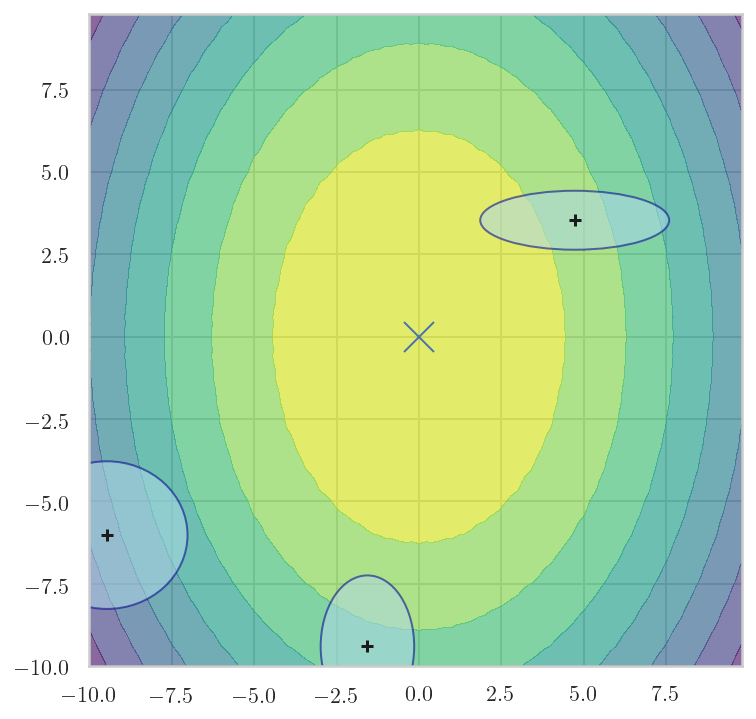

In [ ]:
plot_problem_controur(current_problem, ((-10,-10), (10,10)), optimum=(0,0))
plot_population(pop)

### Mutação de um indivíduo da estratégia evolutiva de acordo com seu atributo de estratégia.
Primeiro, a estratégia é alterada de acordo com uma regra estendida de log normal,
$$
\boldsymbol{\sigma}_t = \exp(\tau_0 \mathcal{N}_0(0, 1)) \left[ \sigma_{t-1, 1}\exp(\tau
\mathcal{N}_1(0, 1)), \ldots, \sigma_{t-1, n} \exp(\tau
\mathcal{N}_n(0, 1))\right],
$$
with
$$\tau_0 =
\frac{c}{\sqrt{2n}}\text{ and }\tau = \frac{c}{\sqrt{2\sqrt{n}}},
$$

o indivíduo é mutado por uma distribuição normal da média 0 e desvio padrão de $\boldsymbol{\sigma}_{t}$ (sua estratégia atual).

Uma escolha recomendada é $c=1$ quando utilizando uma estratégia evolutiva $(10,100)$.

In [ ]:
toolbox.register("mutate", tools.mutESLogNormal, c=1, indpb=0.1)

Blend crossover em ambos, o indivíduo e a estratégia.

In [ ]:
toolbox.register("mate", tools.cxESBlend, alpha=0.1)
#Neste exemplo estamos utilizando uma função da biblioteca de benchmarks do framework, mas você pode definir as sua própria função.
#Por exemplo: def evaluate(individual):
#                 return sum(individual)
#toolbox.register("evaluate", evaluate)
toolbox.register("evaluate", current_problem)
toolbox.register("select", tools.selBest)

In [ ]:
mu_es, lambda_es = 3,21

pop = toolbox.population(n=mu_es)
#retorna a melhor solução da população
hof = tools.HallOfFame(1)

#ferramenta para armazenar as estatísticas da evolução
pop_stats = tools.Statistics(key=copy.deepcopy)
pop_stats.register('pop', copy.deepcopy) # -- copia as próprias populações

#executa uma das 4 formas definidas de algoritmo no framework, nesse caso é o modelo de ES(mu,lambda)
#é possível definir seu próprio algoritmo.
pop, logbook = algorithms.eaMuCommaLambda(pop, toolbox, mu=mu_es, lambda_=lambda_es,
        cxpb=0.6, mutpb=0.3, ngen=40, stats=pop_stats, halloffame=hof, verbose=False)

Exemplo de esquema próprio de evolução usando as funções do DEAP


def main():

    pop = toolbox.population(n=50)
    CXPB, MUTPB, NGEN = 0.5, 0.2, 40

    # Evaluate the entire population
    fitnesses = map(toolbox.evaluate, pop)
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit

    for g in range(NGEN):
        # Select the next generation individuals
        offspring = toolbox.select(pop, len(pop))
        # Clone the selected individuals
        offspring = map(toolbox.clone, offspring)

        # Apply crossover and mutation on the offspring
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < CXPB:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < MUTPB:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # The population is entirely replaced by the offspring
        pop[:] = offspring

    return pop

### The final population

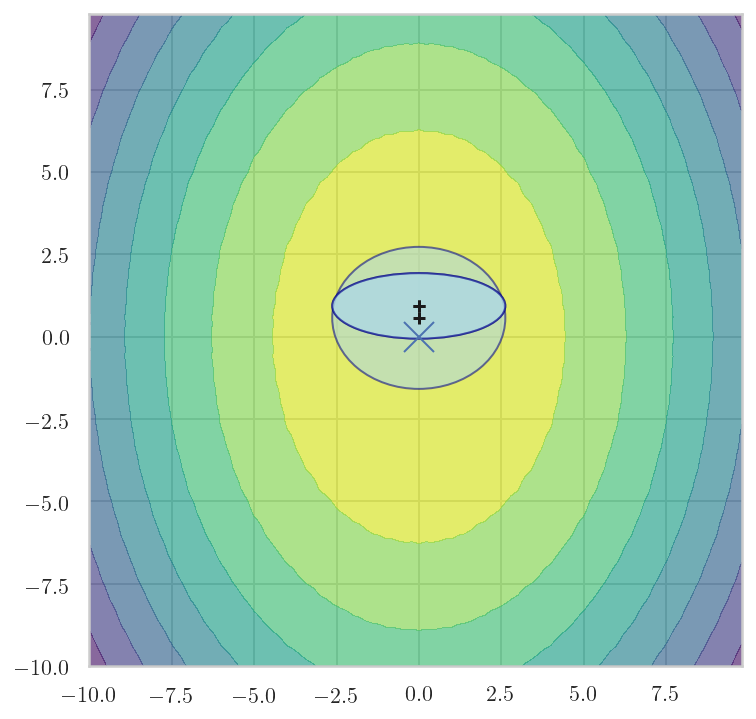

In [ ]:
plot_problem_controur(current_problem, ((-10,-10), (10,10)), optimum=(0,0))
plot_population(pop)

The plot (most probably) shows a "dark blue" ellipse as all individuals are overlapping.

Let's see how the evolutionary process took place in animated form.

In [ ]:
from matplotlib import animation
from IPython.display import HTML

In [ ]:
def animate(i):
    'Updates all plots to match frame _i_ of the animation.'
    ax.clear()
    plot_problem_controur(current_problem, ((-10.1,-10.1), (10.1,10.1)), optimum=(0,0), ax=ax)
    plot_population(logbook[i]['pop'], ax=ax)
    ax.set_title('$t=$' +str(i))
    return []

In [ ]:
fig = plt.figure(figsize=(5,5))
ax = fig.gca()
anim = animation.FuncAnimation(fig, animate, frames=len(logbook), interval=300, blit=True)
plt.close()

In [ ]:
HTML(anim.to_html5_video())

How the population progressed as the evolution proceeded?

In [ ]:
pop = toolbox.population(n=mu_es)

stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

pop, logbook = algorithms.eaMuCommaLambda(pop, toolbox,
                                          mu=mu_es, lambda_=lambda_es,
                                          cxpb=0.6, mutpb=0.3,
                                          ngen=40, stats=stats,
                                          verbose=False)

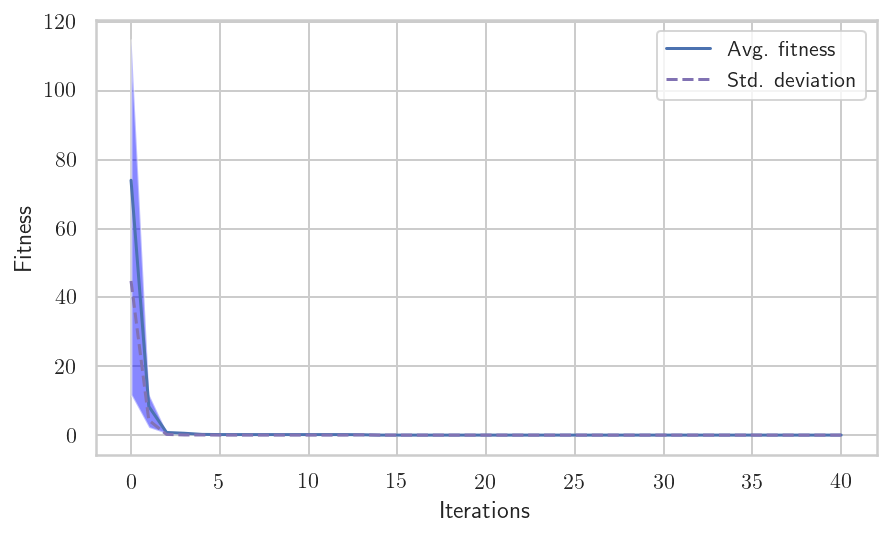

In [ ]:
plt.figure(1, figsize=(7, 4))
plt.plot(logbook.select('avg'), 'b-', label='Avg. fitness')
plt.fill_between(range(len(logbook)), logbook.select('max'), logbook.select('min'), facecolor='blue', alpha=0.47)
plt.plot(logbook.select('std'), 'm--', label='Std. deviation')
plt.legend(frameon=True)
plt.ylabel('Fitness'); plt.xlabel('Iterations');

What happens if we increase $\mu$ and $\lambda$?

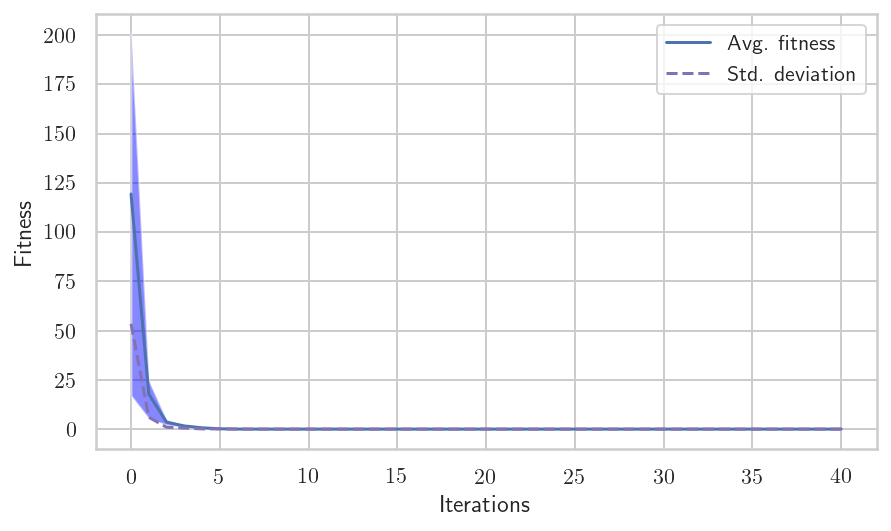

In [ ]:
mu_es, lambda_es = 10,100
pop, logbook = algorithms.eaMuCommaLambda(toolbox.population(n=mu_es), toolbox, mu=mu_es, lambda_=lambda_es,
        cxpb=0.6, mutpb=0.3, ngen=40, stats=stats, halloffame=hof, verbose=False)
plt.figure(1, figsize=(7, 4))
plt.plot(logbook.select('avg'), 'b-', label='Avg. fitness')
plt.fill_between(range(len(logbook)), logbook.select('max'), logbook.select('min'), facecolor='blue', alpha=0.47)
plt.plot(logbook.select('std'), 'm--', label='Std. deviation')
plt.legend(frameon=True)
plt.ylabel('Fitness'); plt.xlabel('Iterations');

Atividades

Nesta atividade vamos explorar o desempenho e o efeito dos parâmetros nas estratégias evolutivas. Para isso iremos utilizar o framework mealpy ([mealpy · PyPI](https://pypi.org/project/mealpy/)). Em anexo a tarefa está disponível o código inicial para os testes.

Na área de computação evolutiva existem uma série de challenges para otimização de funções que são propostos pelas conferências da área. Um bem conhecido é o promovido pelo Congresso de computação evolutiva do IEEE (CEC). Nesta tarefa iremos utilizar algumas funções propostas por essa competição e disponibilizadas no framework. Mais detalhes sobre as funções vocês podem obter em [opfunu](https://github.com/thieu1995/opfunu) e [CEC2014](https://github.com/P-N-Suganthan/CEC2014/blob/master/Definitions%20of%20%20CEC2014%20benchmark%20suite%20Part%20A.pdf).

Para todas as funções serão utilizados as seguintes configurações:



*   Intervalo das variáveis de [-100, 100]
*   10 variáveis




A primeira função é a Rotated High Conditioned Elliptic Function.


O código base está implementado com essa função. Apresente os gráficos obtidos para a configuração apresentada no código base.

Qual efeito pode ser observado no gráfico  da função de fitness, quando ocorre a inversão de valores de exploration e exploitation?

Altere os valores de epoch (número de iterações) e pop_size para as combinações a seguir e compare os valores de global fitness obtidos. Execute o código algumas vezes para cada uma das configurações. Qual delas obteve o melhor resultado?

*   Epoch = 500, pop_size = 100
*   Epoch = 1000, pop_size = 100
*   Epoch = 1000, pop_size = 200

		Apresente alguns dos gráficos obtidos para comparação


Segunda função é a F6 - Shifted and Rotated Weierstrass Function. Essa é uma função chamada de multimodal, onde existem muitos picos.


Altera o código base para essa nova função. Apresente os gráficos obtidos para a configuração apresentada no código base para F1.

Altere os valores de epoch (número de iterações) e pop_size para as combinações a seguir e compare os valores de global fitness obtidos. Execute o código algumas vezes para cada uma das configurações. Qual delas obteve o melhor resultado?

*   Epoch = 500, pop_size = 100
*   Epoch = 1000, pop_size = 100
*   Epoch = 1000, pop_size = 200

    Apresente alguns dos gráficos obtidos para comparação
